## Neal's funnel: Centered and Non-Centered parameterization
author: @karm-patel


Please find numpyro implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/11/neals_funnel_numpyro.ipynb

In [13]:
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils import blackjax_utils

try:
    import blackjax
except:
    %pip install blackjax
    import blackjax


import arviz as az
import matplotlib.pyplot as plt
import jax
from jax import random
import jax.numpy as jnp

try:
    import tensorflow_probability.substrates.jax as tfp
except:
    %pip install tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

import os
import seaborn as sns

In [ ]:
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures/"

In [4]:
pml.latexify(width_scale_factor=3, fig_height=1.5)

/home/patel_karm/anaconda3/envs/py3713_2/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


We use following toy model to create a funnel like plot (from section 11.6.4, book2)
\begin{align}
  \nu &\sim \mathcal{N}(0,3) \\
  x &\sim  \mathcal{N}(0, exp(\nu/2))
\end{align}
<!-- \begin{align}
  log\sigma &\sim \mathcal{N}(0,1.5) \\
  x &\sim  \mathcal{N}((0, \sigma))
\end{align} -->

In [5]:
n = 500
v_dist = tfd.Normal(0, 3)  # here v denotes log(variance)
x_dist = lambda v: tfd.Normal(0, jnp.exp(v / 2))

min_v, max_v = -5, 5
min_x, max_x = -5, 5

In [6]:
x_range, v_range = jnp.linspace(min_x, max_x, n), jnp.linspace(min_v, max_v, n)
x_mesh, v_mesh = jnp.meshgrid(x_range, v_range)
log_joint_mesh = v_dist.log_prob(v_mesh) + x_dist(v_mesh).log_prob(x_mesh)
pmin = jnp.percentile(log_joint_mesh.flatten(), 42)  # remove very low probability regions
log_joint_mesh = jnp.where(log_joint_mesh < pmin, jnp.nan, log_joint_mesh)

/home/patel_karm/anaconda3/envs/py3713_2/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


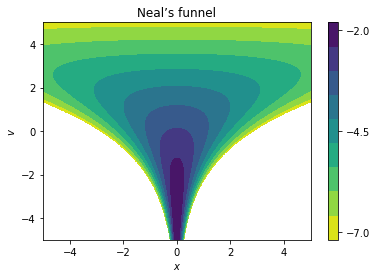

In [7]:
fig, ax = plt.subplots()
cf = ax.contourf(x_range, v_range, log_joint_mesh, cmap="viridis_r", levels=8)
ax.set_ylabel("$v$")
ax.set_xlabel("$x$")
cbar = fig.colorbar(cf)
cbar.set_ticks(jnp.linspace(-7, -2, 3))
# ax.set_aspect("equal")
ax.set_title("Neal’s funnel")
pml.savefig("nealsFunnel", tight_bbox=True)

In [8]:
step_size = 1.1
inverse_mass_matrix = jnp.array([0.5, 0.5])
n_samples = 1000
rng_key = jax.random.PRNGKey(0)
MARKER_SIZE = 1 if pml.is_latexify_enabled() else None

## Funnel samples with centered parameterization

In [9]:
def log_joint_centered(params):
    x, v = params["x"], params["v"]
    return tfd.Normal(0, 3).log_prob(v) + tfd.Normal(0, jnp.exp(v / 2)).log_prob(x)

In [10]:
nuts = blackjax.nuts(log_joint_centered, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix)
initial_position = {"x": 0.0, "v": 0.0}
initial_state = nuts.init(initial_position)
initial_state

HMCState(position={'x': 0.0, 'v': 0.0}, potential_energy=DeviceArray(2.9364896, dtype=float32), potential_energy_grad={'v': DeviceArray(0.5, dtype=float32, weak_type=True), 'x': DeviceArray(0., dtype=float32, weak_type=True)})

In [14]:
%%time
kernel = jax.jit(nuts.step)
states, infos = pml.blackjax_utils.inference_loop(rng_key, kernel, initial_state, n_samples)

CPU times: user 1.97 s, sys: 21 ms, total: 1.99 s
Wall time: 1.94 s


/home/patel_karm/anaconda3/envs/py3713_2/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


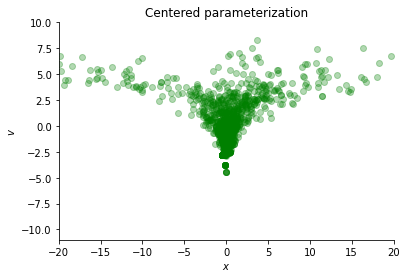

In [15]:
fig, ax = plt.subplots()
ax.plot(states.position["x"], states.position["v"], "go", alpha=0.3, markersize=MARKER_SIZE, label="samples")
ax.set(ylim=(-11, 10), xlim=(-20, 20), xlabel="$x$", ylabel="$v$")
ax.set_title("Centered parameterization")
sns.despine()
pml.savefig("funnel_plot_centered")

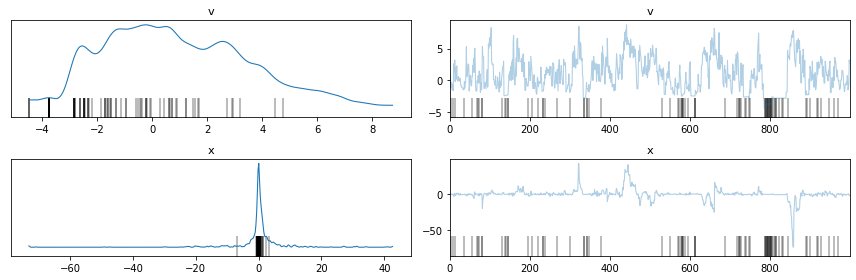

In [18]:
trace = blackjax_utils.arviz_trace_from_states(states, infos)
az.plot_trace(trace)
plt.tight_layout()

In [19]:
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.920,2.613,-2.847,6.109,0.350,0.248,51.0,20.0,NaN
x,0.088,7.940,-15.585,11.821,1.819,1.307,26.0,50.0,NaN


## Non-centered

We use reparameterized form to take samples
\begin{align}
  \nu &\sim  \mathcal{N}(0,3) \\
  z &\sim \mathcal{N}(0,1) \\
  x &= z \exp(\nu/2)
  \end{align}

In [20]:
def log_joint_non_centered(params):
    v, z = params["v"], params["z"]
    return tfd.Normal(0, 3).log_prob(v) + tfd.Normal(0, 1).log_prob(z)

In [21]:
nuts_nc = blackjax.nuts(log_joint_non_centered, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix)
initial_position_nc = {"v": 5.0, "z": 1.0}
initial_state_nc = nuts_nc.init(initial_position_nc)
initial_state_nc

HMCState(position={'v': 5.0, 'z': 1.0}, potential_energy=DeviceArray(4.8253784, dtype=float32), potential_energy_grad={'v': DeviceArray(0.5555555, dtype=float32, weak_type=True), 'z': DeviceArray(1., dtype=float32, weak_type=True)})

In [22]:
%%time
kernel = jax.jit(nuts_nc.step)
states_nc, infos_nc = blackjax_utils.inference_loop(rng_key, kernel, initial_state_nc, n_samples)

CPU times: user 1.78 s, sys: 23.2 ms, total: 1.8 s
Wall time: 1.75 s


In [23]:
samples_nc = states_nc.position

/home/patel_karm/anaconda3/envs/py3713_2/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


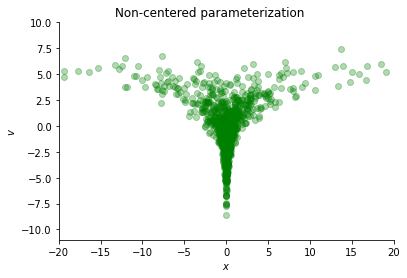

In [24]:
fig, ax = plt.subplots()
x = samples_nc["z"] * jnp.exp(samples_nc["v"] / 2)
ax.plot(x, samples_nc["v"], "go", alpha=0.3, markersize=MARKER_SIZE)
ax.set(ylim=(-11, 10), xlim=(-20, 20), xlabel="$x$", ylabel="$v$")
sns.despine()
ax.set_title("Non-centered parameterization", x=0.45)
pml.savefig("funnel_plot_noncentered")

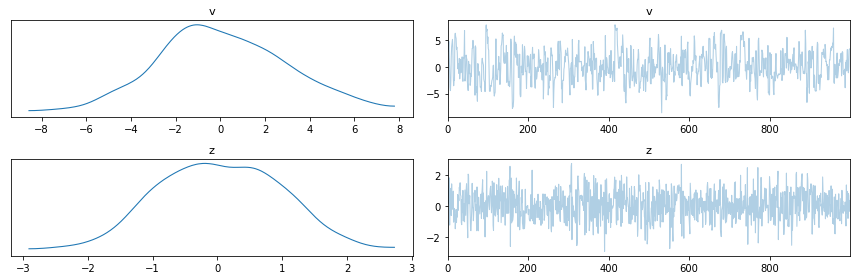

In [26]:
trace = blackjax_utils.arviz_trace_from_states(states_nc, infos_nc, burn_in=0)
az.plot_trace(trace)
plt.tight_layout()

In [27]:
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.099,2.899,-5.497,5.372,0.153,0.123,362.0,331.0,NaN
z,0.033,0.963,-1.610,1.881,0.031,0.029,955.0,716.0,NaN
